# Generate Inputs for Evotuning eUniRep

1. Get input FASTA files from doing PFAM search on wild type protein, then downloading related clans on InterPro. In this case the wild type protein was isPETase, and the PFAM clans downloaded were DLH, cutinases, and lipases. DLH was the best match clan, cutinases and lipases were chosen as they were clans within the same family (A/B fold hydrolases). Out of the 70 clans in the family those 2 were chosen as they are specificially referenced several times across PETase engineering literature.

2. Clean the inputs by removing sequences with non-standard residues, anything with length greater than k (in this case k = 600), remove duplicate sequences.

3. Calculate levenstein distances from highly desired mutant (i.e. duraPETase) on all clean sequences.

4. Generate training, in_domain validation and out_domain validation sets. out_domain validation set is generated first uusing a distribution proportional to distances^4 - taking 10% of the total sequences. Then 10% of the total (11.1% of the remainder) is taken for the in_domain validation set, with the remaining 80% of original = the training set.

5. Convert resulting split set of sequences into input format required by UniRep and output to a .fasta.txt file 

In [1]:
from Bio import SeqIO
import pandas as pd
import re
from Levenshtein import distance
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Functions:

# read FASTA file:
# input: file name
# output: names and sequences in the file as an array of dim-2 arrays [name, sequence].
def read_fasta(name):
    fasta_seqs = SeqIO.parse(open('inputs/' + name + '.fasta.txt'),'fasta')
    data = []
    for fasta in fasta_seqs:
        data.append([fasta.id, str(fasta.seq).strip()])
    
    return data


# write FASTA file:
# input: file name; df to write
def write_fasta(name, seqs_df):
    out_file = open('outputs/' + name + '.fasta.txt', "w")
    for i in range(len(seqs_df)):
        out_file.write('>' + seqs_df.name[i] + '\n')
        out_file.write(seqs_df.sequence[i] + '\n')
    out_file.close()


# input: takes in a sequence
# output: True if a sequence contains only standard amino acids, returns False if contains non-standard ones.
def validate(seq, pattern=re.compile(r'^[FIWLVMYCATHGSQRKNEPD]+$')):
    if (pattern.match(seq)):
        return True
    return False

    
# Remove sequences longer than k residues and with non-standard residues
# inputs: seqs_df = dataframe of name, sequence; k = max lenght of residues to keep
# output: cleaned dataframe
def clean(seqs_df, k):
    # remove sequences with length > 1000 AA's
    rows2drop = []
    for i in range(len(seqs_df)):
        if (len(seqs_df.sequence[i]) > k):
            rows2drop.append(i)

    print('Total number of sequences dropped:', len(rows2drop))

    seqs_df = seqs_df.drop(rows2drop).reset_index().drop('index', axis=1)

    print('Total number of sequences remaining:', len(seqs_df))
    
    # remove sequences with invalid AA residues
    # valid_alphabet = ['F','I','W','L','V','M','Y','C','A','T','H','G','S','Q','R','K','N','E','P','D']
    invalid_seqs = []

    for i in range(len(seqs_df)):
        if (not validate(seqs_df.sequence[i])):
            invalid_seqs.append(i)

    print('Total number of sequences dropped:', len(invalid_seqs))

    seqs_df = seqs_df.drop(invalid_seqs).reset_index().drop('index', axis=1)

    print('Total number of sequences remaining:', len(seqs_df))
    
    
    seqs_df = seqs_df.drop_duplicates(subset='sequence').reset_index().drop('index', axis=1)

    print('Total sequences remaining after duplicate removal', len(seqs_df))

    
    return seqs_df


# calculate the Levenstein distance of mulitple sequences to a target sequence
# also plots a histogram of distances
# inputs: t_seq = target sequence; seqs_df = dataframe of sequences;
# num_bins = bins for histogram; hist_range = range for histogram
# outputs: numpy array of distances
def lev_dist(t_seq, seqs_df, num_bins=20, hist_range=(0,350)):
    distances = []
    for i in range(len(seqs_df)):
        distances.append(distance(t_seq, seqs_df.sequence[i]))
    distances = np.array(distances)

    mean_dist = np.mean(distances)
    median_dist = np.median(distances)
    min_dist = np.min(distances)
    max_dist = np.max(distances)
    
    print("Mean Levenstein distance:", mean_dist)
    print("Median Levenstein distance:", mean_dist)
    print("Min Levenstein distance:", min_dist)
    print("Max Levenstein distance:", max_dist)

    
    # histogram of Levenstein distances from target sequence
    plt.clf()
    plt.hist(distances, bins=num_bins, range=hist_range)
    plt.show()
    
    return distances



"""
File formatting note.
Data should be preprocessed as a sequence of comma-seperated ints with
sequences  /n seperated
"""

# Lookup tables
aa_to_int = {
    'M':1,
    'R':2,
    'H':3,
    'K':4,
    'D':5,
    'E':6,
    'S':7,
    'T':8,
    'N':9,
    'Q':10,
    'C':11,
    'U':12,
    'G':13,
    'P':14,
    'A':15,
    'V':16,
    'I':17,
    'F':18,
    'Y':19,
    'W':20,
    'L':21,
    'O':22, #Pyrrolysine
    'X':23, # Unknown
    'Z':23, # Glutamic acid or GLutamine
    'B':23, # Asparagine or aspartic acid
    'J':23, # Leucine or isoleucine
    'start':24,
    'stop':25,
}

int_to_aa = {value:key for key, value in aa_to_int.items()}

def get_aa_to_int():
    """
    Get the lookup table (for easy import)
    """
    return aa_to_int

def get_int_to_aa():
    """
    Get the lookup table (for easy import)
    """
    return int_to_aa
    
def aa_seq_to_int(s):
    """
    Return the int sequence as a list for a given string of amino acids
    """
    return [24] + [aa_to_int[a] for a in s] + [25]

def int_seq_to_aa(s):
    """
    Return the int sequence as a list for a given string of amino acids
    """
    return "".join([int_to_aa[i] for i in s])

    
def format_seq(seq,stop=False):
    """
    Takes an amino acid sequence, returns a list of integers in the codex of the babbler.
    Here, the default is to strip the stop symbol (stop=False) which would have 
    otherwise been added to the end of the sequence. If you are trying to generate
    a rep, do not include the stop. It is probably best to ignore the stop if you are
    co-tuning the babbler and a top model as well.
    """
    if stop:
        int_seq = aa_seq_to_int(seq.strip())
    else:
        int_seq = aa_seq_to_int(seq.strip())[:-1]
    return int_seq

def is_valid_seq(seq, max_len=2000):
    """
    True if seq is valid for the babbler, False otherwise.
    """
    l = len(seq)
    valid_aas = "MRHKDESTNQCUGPAVIFYWLO"
    if (l < max_len) and set(seq) <= set(valid_aas):
        return True
    else:
        return False

def fasta_to_input(in_path):
    source = SeqIO.parse(in_path + '.fasta.txt','fasta')
    with open(in_path + "_formatted.fasta.txt", "w") as destination:
        for seq in fasta_seqs:
            seq = seq.strip()
            if is_valid_seq(seq) and len(seq) < 275: 
                formatted = ",".join(map(str,format_seq(seq)))
                destination.write(formatted)
                destination.write('\n')

def seqs_to_input(name, in_seqs, stop=False):
    with open('outputs/' + name + "_formatted.fasta.txt", "w") as destination:
        for seq in in_seqs:
            seq = seq.strip()
            if is_valid_seq(seq): 
                formatted = ",".join(map(str,format_seq(seq, stop=stop)))
                destination.write(formatted)
                destination.write('\n')


In [3]:
# input FASTA files:
in_fasta_1 = 'dlh'
in_fasta_2 = 'cutinase'
in_fasta_3 = 'lipase'

# put sequences into a pandas dataframes
sequences_1_df = pd.DataFrame(read_fasta(in_fasta_1), columns = ['name', 'sequence'])
sequences_2_df = pd.DataFrame(read_fasta(in_fasta_2), columns = ['name', 'sequence'])
sequences_3_df = pd.DataFrame(read_fasta(in_fasta_3), columns = ['name', 'sequence'])

# concatinate the dataframes vertically (i.e. stack them)
sequences_df = pd.concat([sequences_1_df, sequences_2_df, sequences_3_df], axis=0).reset_index().drop('index', axis=1)

print('Total number of input sequences:', len(sequences_df))

# clean the sequences:
# the number here is the AA length we want - set to 600 as that was what was used for TEM-1
clean_seqs_df = clean(sequences_df, 600)

# save clean sequences as a .fasta.txt file
write_fasta('all_sequences_clean', clean_seqs_df)

Total number of input sequences: 92236
Total number of sequences dropped: 2235
Total number of sequences remaining: 90001
Total number of sequences dropped: 968
Total number of sequences remaining: 89033
Total sequences remaining after duplicate removal 80328


In [4]:
# load target sequence
target_fasta = 'duraPETase'
targets = read_fasta(target_fasta)
print(targets[0][0])
print(targets[0][1])


duraPETase
MNFPRASRLMQAAVLGGLMAVSAAATAQTNPYARGPNPTAASLEASAGPFTVRSFTVSRPSGYGAGTVYYPTNAGGTVGAIAIVPGYTARQSSIKWWGPRLASHGFVVITIDTNSTFDYPSSRSSQQMAALRQVASLNGDSSSPIYGKVDTARMGVMGHSMGGGASLRSAANNPSLKAAIPQAPWDSQTNFSSVTVPTLIFACENDSIAPVNSHALPIYDSMSRNAKQFLEINGGSHSCANSGNSNQALIGKKGVAWMKRFMDNDTRYSTFACENPNSTAVSDFRTANCS


Mean Levenstein distance: 245.02161139328751
Median Levenstein distance: 245.02161139328751
Min Levenstein distance: 10
Max Levenstein distance: 474


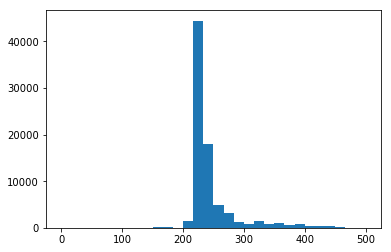

In [5]:
# calculate levenstein distance from chosen target sequence
distances = lev_dist(targets[0][1], clean_seqs_df, 30, (0,500))

In [6]:
# partition into the training and 2 validation sets:

clean_seqs_df_copy = clean_seqs_df.copy()
out_domain_val_set = clean_seqs_df_copy.sample(frac=0.1, weights=distances**4, random_state=17)
remainder_df = clean_seqs_df_copy.drop(out_domain_val_set.index)
train_set = remainder_df.sample(frac=0.889, random_state=17)
in_domain_val_set = remainder_df.drop(train_set.index)


In [7]:
# set check sizes
print('Out of domain validation set size:', len(out_domain_val_set))
print('In domain validation set size:', len(in_domain_val_set))
print('Training set size:', len(train_set))

Out of domain validation set size: 8033
In domain validation set size: 8025
Training set size: 64270


In [8]:
# save to fasta file formats:

write_fasta('train_set', train_set.reset_index().drop('index', axis=1))
write_fasta('out_domain_val_set', out_domain_val_set.reset_index().drop('index', axis=1))
write_fasta('in_domain_val_set', in_domain_val_set.reset_index().drop('index', axis=1))


In [9]:
# convert to input representation needed by eUniRep and output as fasta text files

seqs_to_input('train_set', train_set.sequence, stop=True)
seqs_to_input('out_domain_val_set', out_domain_val_set.sequence, stop=True)
seqs_to_input('in_domain_val_set', in_domain_val_set.sequence, stop=True)